# Data wrangling for Capstone Project 1

## 0. Introduction to the datasets

The raw data files in this project are acquired from UCI Repository at: 
1) https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities
2) https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data 

These raw csv files include:
    1) ‘beijing.csv’, ’shanghai.csv’, ‘guangzhou.csv’, ‘chengdu.csv’, ‘shenyang.csv’
These five csv files contain hourly PM2.5 measurements for five major Chinese cities respectively, along with many other meteorological readings collected during the period of 2010-2015. These meteorological readings include dew point (‘DEWP’), temperature(‘TEMP’), humidity(‘HUMI’), pressure(‘PRES’), combined wind direction(‘cbwd’), cumulative wind speed (‘Iws’), hourly precipitation (‘precipitation’) and cumulative precipitation (‘Iprec’). 
    2) ‘beijing_2.csv’
This csv file contains similar hourly measurement data for city Beijing alone during the period of 2010-2014, with two unique columns, cumulative hours of snow (‘Is’) and cumulative hours of rain (‘Ir’). 

## 1. Import relevant modules & raw data files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#create an empty list named dfs to temperarily store individual dfs for concatenating later
dfs=[]

#import data from six csv files for five cities into pandas using pd.read_csv
citynames=['beijing','shanghai','guangzhou','chengdu','shenyang','beijing_2']
for cityname in citynames:
    df=pd.read_csv('datasets/{}.csv'.format(cityname))
    #add a column 'City' to each dataset to store the city information for the corresponding dataset
    df['city']=cityname
    #append each df to the list dfs
    dfs.append(df)

#concatenate all dfs into a single dataframe named pm_raw, which stores the combined raw dataset
pm_raw=pd.concat(dfs, sort=False)
#reset index after concatenation and discard the original index
pm_raw=pm_raw.reset_index(drop=True)
print(pm_raw.head())

   No  year  month  day  hour  season  PM_Dongsi  PM_Dongsihuan  \
0   1  2010      1    1     0     4.0        NaN            NaN   
1   2  2010      1    1     1     4.0        NaN            NaN   
2   3  2010      1    1     2     4.0        NaN            NaN   
3   4  2010      1    1     3     4.0        NaN            NaN   
4   5  2010      1    1     4     4.0        NaN            NaN   

   PM_Nongzhanguan  PM_US Post ...  PM_Xuhui  PM_City Station  \
0              NaN         NaN ...       NaN              NaN   
1              NaN         NaN ...       NaN              NaN   
2              NaN         NaN ...       NaN              NaN   
3              NaN         NaN ...       NaN              NaN   
4              NaN         NaN ...       NaN              NaN   

   PM_5th Middle School  PM_Caotangsi PM_Shahepu  PM_Taiyuanjie  PM_Xiaoheyan  \
0                   NaN           NaN        NaN            NaN           NaN   
1                   NaN           NaN       

## 2. Understanding the dataset & Choose data wrangling strategies

In [2]:
#overview of the size, structure, data types and quality of the data
print(pm_raw.info())

#compare the subsets
print('Beijing:\n',pm_raw[pm_raw['city'] == 'beijing'].dropna(axis='columns',how='all').columns)
print('Shanghai:\n',pm_raw[pm_raw['city'] == 'shanghai'].dropna(axis='columns',how='all').columns)
print('Guangzhou:\n',pm_raw[pm_raw['city'] == 'guangzhou'].dropna(axis='columns',how='all').columns)
print('Chengdu:\n',pm_raw[pm_raw['city'] == 'chengdu'].dropna(axis='columns',how='all').columns)
print('Shenyang:\n',pm_raw[pm_raw['city'] == 'shenyang'].dropna(axis='columns',how='all').columns)
print('Beijing_2:\n',pm_raw[pm_raw['city'] == 'beijing_2'].dropna(axis='columns',how='all').columns)

#overview of the descriptive statistics for numerical columns
print(pm_raw.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306744 entries, 0 to 306743
Data columns (total 30 columns):
No                      306744 non-null int64
year                    306744 non-null int64
month                   306744 non-null int64
day                     306744 non-null int64
hour                    306744 non-null int64
season                  262919 non-null float64
PM_Dongsi               25052 non-null float64
PM_Dongsihuan           20508 non-null float64
PM_Nongzhanguan         24931 non-null float64
PM_US Post              167358 non-null float64
DEWP                    305504 non-null float64
HUMI                    261352 non-null float64
PRES                    305163 non-null float64
TEMP                    305506 non-null float64
cbwd                    305513 non-null object
Iws                     305501 non-null float64
precipitation           242708 non-null float64
Iprec                   242708 non-null float64
city                    306744 non-null

This is a large time series dataset with 306744 rows and 30 columns, as a combination of datetime records and various measurements taken at multiple stations in each city for a total of five cites in China from year 2010 to 2015. Given the large size of this raw dataset, the approach is to divide it into a few subsets according to the characteristics of this dataset.

### Characteristis of the dataset:
1) Common columns: 
    - datetime related columns: 'year','month','day','hour','season'
    - measurement related columns: 'PM_US Post','DEWP','HUMI','PRES','TEMP','cbwd','Iws','precipitation','Iprec'
    - other columns: 'No', 'city'
    Note: datetime information is stored in separated columns as 'year', 'month', etc. For further analysis and plotting purpose, it's better to include an additional DateTime column combining all these time related columns. 
    
2) city-specific columns: 
   In addition to the PM2.5 data from the local 'PM_US Post' for all five cities, additional PM2.5 data are included from different stations for each city, and labeled by their station-specific column names. e.g.:
    - beijing: 'PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan'
    - shanghai: 'PM_Jingan','PM_Xuhui'
    - guangzhou: 'PM_City Station', 'PM_5th Middle School' 
    - chengdu: 'PM_Caotangsi', 'PM_Shahepu'
    - shenyang: 'PM_Taiyuanjie', 'PM_Xiaoheyan'
   There is no reason to choose the PM2.5 data from one station over those from other stations, therefore it's better to take the average of all PM2.5 readings (including 'PM_US Post') for each city as the representative PM2.5 data for most of the analysis and visualization purposes. 
   In addition, the station-specific individual PM2.5 readings will be extracted as a separate dataset for comparing the measurement consistency among stations for each city.
   
3) Measurement-specific columns:
   Besides the dataset for 'beijing', there is another set for 'beijing_2', which contains mostly redundant data as dataset 'beijing', except for the columns 'Is' and 'Ir'.(Note: 'pm2.5' column from 'beijing_2' dataset contains the same data as 'PM_US Post' column from 'beijing'). 
   Here, 'Is' and 'Ir' refer to 'Cumulated hours of snow' and 'Cumulated hours of rain', respectively, whereas in the original dataset 'beijing', only 'precipitation' and 'Iprec' representing 'Cumulated hours of precipitation' are available. In this case, we will extract this subset containing 'Is' and 'Ir' for city 'beijing' as a separate dataset for comparing the impact of snow versus rain.

4) Missing data and outliers:
    As suggested above, there are many missing data in several columns. Also, suspicious large data points are spotted from descriptive satistics, indicating outliers. These problems need to be investigated and addressed properly. 
    
### Data wrangling strategies:
We will separate the raw dataset pm_raw into three separate datasets for cleaning, analysis and visualization:
    1) pm_clean: this is the main dataset containing the measurement data for all five cities, here the average pm2.5 reading for each city is used instead of pm2.5 data from individual stations
    2) pm_stations: this is a side dataset containing station-specific individual PM2.5 readings. This dataset serves the purpose of comparing the measurement consistency among stations for each city.
    3) pm_sr: this is also a side dataset containing information on cumulated hours of snows and rains for city 'beijing'. This dataset serves the purpose of comparing the impact of snow versus rain on PM2.5 readings.
    
Two additional columns will be added: 
    1) 'date_time': DateTime format by combining 'year','month','day','hour'columns
    2) 'pm_average': float values representing the average of pm2.5 readings from multiple stations of the same city
    
Missing values and outliers will be evaluated and addressed. 

## 3. pm_clean

In [3]:
#copy relevant columns from pm_raw and store in the main dataset pm_clean

print(pm_raw.columns)
pm_clean = pm_raw[['year','month','day','hour','season','DEWP','HUMI','PRES','TEMP','cbwd','Iws','precipitation','Iprec','city']]
print(pm_clean.info())

Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi',
       'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec', 'city',
       'PM_Jingan', 'PM_Xuhui', 'PM_City Station', 'PM_5th Middle School',
       'PM_Caotangsi', 'PM_Shahepu', 'PM_Taiyuanjie', 'PM_Xiaoheyan', 'pm2.5',
       'Is', 'Ir'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306744 entries, 0 to 306743
Data columns (total 14 columns):
year             306744 non-null int64
month            306744 non-null int64
day              306744 non-null int64
hour             306744 non-null int64
season           262919 non-null float64
DEWP             305504 non-null float64
HUMI             261352 non-null float64
PRES             305163 non-null float64
TEMP             305506 non-null float64
cbwd             305513 non-null object
Iws              305501 non-null float64
precipitation    242708 non-null float

In [4]:
#drop irrelevant data in pm_clean

#drop all data from pm_clean where 'city' is 'beijing_2', these data is intended to be handled in a separate subset pm_sr
pm_clean = pm_clean[pm_clean['city'] != 'beijing_2']
#update index
pm_clean.reset_index(drop=True,inplace=True)

#doublecheck after dropping to make sure rows for 'beijing_2' has been removed
print(pm_clean.info())
print(pm_clean['city'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262920 entries, 0 to 262919
Data columns (total 14 columns):
year             262920 non-null int64
month            262920 non-null int64
day              262920 non-null int64
hour             262920 non-null int64
season           262919 non-null float64
DEWP             261680 non-null float64
HUMI             261352 non-null float64
PRES             261339 non-null float64
TEMP             261682 non-null float64
cbwd             261689 non-null object
Iws              261677 non-null float64
precipitation    242708 non-null float64
Iprec            242708 non-null float64
city             262920 non-null object
dtypes: float64(8), int64(4), object(2)
memory usage: 28.1+ MB
None
shanghai     52584
beijing      52584
chengdu      52584
shenyang     52584
guangzhou    52584
Name: city, dtype: int64


In [5]:
#set all column names to be lowercase names
pm_clean.columns=pm_clean.columns.str.lower()
print(pm_clean.columns)

Index(['year', 'month', 'day', 'hour', 'season', 'dewp', 'humi', 'pres',
       'temp', 'cbwd', 'iws', 'precipitation', 'iprec', 'city'],
      dtype='object')


In [6]:
#create a new Series 'pm_average' for the average PM2.5 readings from all relevant stations and append it to the main dataset pm_clean

#find and store the column names for pm2.5 readigns from pm_raw
print(pm_raw.columns)
stations = ['PM_US Post','PM_Dongsi','PM_Dongsihuan','PM_Nongzhanguan','PM_Jingan','PM_Xuhui','PM_City Station','PM_5th Middle School','PM_Caotangsi','PM_Shahepu','PM_Taiyuanjie','PM_Xiaoheyan']

#calculate the mean across all pm2.5 columns
#note: during importing, pm readings are autofilled with NaNs (missing station data) for stations not belong to the city in that row
#these NaNs from irrelevant stations will not participate in the calculation of the mean
pm_average = pm_raw[pm_raw['city'] != 'beijing_2'].loc[:,stations].mean(axis=1,skipna=True)
pm_average.name='pm_average'

#check the length of pm_average before concatenating horizontally
assert len(pm_average) == len(pm_clean)

#append pm_average to pm_clean horizontally
pm_clean = pd.concat([pm_clean,pm_average], axis=1)
print(pm_clean.info())

Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi',
       'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec', 'city',
       'PM_Jingan', 'PM_Xuhui', 'PM_City Station', 'PM_5th Middle School',
       'PM_Caotangsi', 'PM_Shahepu', 'PM_Taiyuanjie', 'PM_Xiaoheyan', 'pm2.5',
       'Is', 'Ir'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262920 entries, 0 to 262919
Data columns (total 15 columns):
year             262920 non-null int64
month            262920 non-null int64
day              262920 non-null int64
hour             262920 non-null int64
season           262919 non-null float64
dewp             261680 non-null float64
humi             261352 non-null float64
pres             261339 non-null float64
temp             261682 non-null float64
cbwd             261689 non-null object
iws              261677 non-null float64
precipitation    242708 non-null float

In [7]:
#deal with missing data

print(pm_clean.info())

#look into the one missing value in 'season' column
print(pm_clean[pm_clean['season'].isna()])
#note: all the measurement data is missing in the this row except for the 'PM_average' column
#Given the large number of entries available in pm_clean, drop this particular row with many NaNs
pm_clean.dropna(subset=['season'],inplace=True)
assert pm_clean['season'].notnull().all()

#'season' column has a data type of float64, whereas it only has four unique values of 1.0, 2.0, 3.0 and 4.0
print(pm_clean['season'].unique())
#convert the data type of 'season' column from float to int
pm_clean['season'] = pm_clean['season'].astype(int)
print(pm_clean.info())

#columns 'DEWP','HUMI','PRES','TEMP','cbwd','Iws','precipitation','Iprec','PM_average' have some missing data
#use method='ffill' and limit=1 to fill in missing values along columns forward for up to only one row to prevent obscuring the trend by extending a value to too many NaNs
pm_clean.fillna(method='ffill',limit=1,inplace=True)
print(pm_clean.info())
#use method='bfill' and limit=1 to fill in missing values along columns backforward for up to only one row
pm_clean.fillna(method='bfill',limit=1,inplace=True)
print(pm_clean.info())

#for the rest of the missing data:
#drop rows with missing PM_average data because PM data is the key focus of further analysis
pm_clean = pm_clean[pm_clean['pm_average'].notna()]
#update index after dropping
pm_clean.reset_index(drop=True,inplace=True)
print(pm_clean.info())

#for the rest of the missing data in columns 'DEWP','HUMI','PRES','TEMP','cbwd','Iws','precipitation','Iprec', leave them as they are
#because the missing values in one of these columns will not affect the correlation between 'PM_average' and other columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262920 entries, 0 to 262919
Data columns (total 15 columns):
year             262920 non-null int64
month            262920 non-null int64
day              262920 non-null int64
hour             262920 non-null int64
season           262919 non-null float64
dewp             261680 non-null float64
humi             261352 non-null float64
pres             261339 non-null float64
temp             261682 non-null float64
cbwd             261689 non-null object
iws              261677 non-null float64
precipitation    242708 non-null float64
iprec            242708 non-null float64
city             262920 non-null object
pm_average       175245 non-null float64
dtypes: float64(9), int64(4), object(2)
memory usage: 30.1+ MB
None
        year  month  day  hour  season  dewp  humi  pres  temp cbwd  iws  \
157751  2015     12   31    23     NaN   NaN   NaN   NaN   NaN  NaN  NaN   

        precipitation  iprec       city  pm_average  
157751   

In [8]:
#create a new column named 'date_time' storing the DateTime format data from time-related columns:'year','month','day','hour'

#explore the values in columns 'year','month','day' and 'hour' first
print(pm_clean['year'].value_counts(dropna=False))
print(pm_clean['month'].value_counts(dropna=False))
print(pm_clean['day'].value_counts(dropna=False))
print(pm_clean['hour'].value_counts(dropna=False))
#the results show no missing info in all these columns, and all values make sense
#there are some single digit data in certain columns ('month','day' and 'hour'), which need to be converted to double digits for fitting to the time format string

#initialize an empty column named 'date_time'
pm_clean['date_time']=''
#iterate through 'year','month','day','hour' columns, convert int/float to string type, append to 'date_time' column
for idx, col in enumerate(pm_clean.columns[0:4]):
    #convert to string data type
    to_str = pm_clean[col].astype(str)
    #for 'month','day' and 'hour', update all string lengths to 2 by filling in 0 from the left  
    to_str = pd.Series([('0'+entry) if len(entry) < 2 else entry for entry in to_str])   
    #use string concatenation to append each time string to the 'date_time' column
    pm_clean['date_time'] += to_str
    
#doublecheck values in 'date_time' column before converting to DateTime format
print(pm_clean['date_time'].head())
#convert 'date_time' column from string object to DateTime object
pm_clean['date_time'] = pd.to_datetime(pm_clean['date_time'], format='%Y%m%d%H')
#doublecheck the values in 'date_time' column after converting
print(pm_clean['date_time'].head(25))

#we kept both individual columns for 'year','month','day','hour','season' and the combined 'date_time' column in the main datset
#the former is great for use in groupby, whereas the later is great for plotting time series data

2014    43796
2015    43779
2013    43405
2012    28022
2011     9123
2010     8142
Name: year, dtype: int64
12    16170
7     15473
10    15420
8     15096
11    15008
9     14840
5     14549
6     14521
3     14333
4     14066
1     13985
2     12806
Name: month, dtype: int64
28    5871
27    5841
26    5840
10    5822
25    5821
24    5820
11    5810
17    5808
13    5808
16    5803
9     5801
23    5798
14    5797
22    5796
21    5789
3     5788
15    5781
12    5774
8     5773
4     5758
2     5743
20    5742
19    5739
18    5736
7     5727
1     5721
5     5708
6     5697
29    5480
30    5423
31    3452
Name: day, dtype: int64
16    7361
22    7359
15    7358
23    7357
14    7355
17    7351
0     7351
11    7348
12    7347
13    7347
21    7345
18    7345
10    7344
9     7344
19    7344
20    7342
8     7341
1     7336
7     7334
5     7334
2     7332
6     7331
4     7331
3     7330
Name: hour, dtype: int64
0    2010010122
1    2010010123
2    2010010200
3    2010010201
4  

In [9]:
#locate potential outliers

#look at the statistics for all numerical columns
print(pm_clean.describe())

#note: 
#max values in 'iws', 'precipitation', 'iprec' and 'pm_average' look unusually large; 
#min values in 'dewp' and 'humi' look unreasonably small/negative;
#these columns could have outliers and require further investigation

                year          month            day           hour  \
count  176267.000000  176267.000000  176267.000000  176267.000000   
mean     2013.344137       6.664310      15.785780      11.505829   
std         1.380304       3.443411       8.807779       6.922122   
min      2010.000000       1.000000       1.000000       0.000000   
25%      2012.000000       4.000000       8.000000       6.000000   
50%      2013.000000       7.000000      16.000000      12.000000   
75%      2014.000000      10.000000      23.000000      18.000000   
max      2015.000000      12.000000      31.000000      23.000000   

              season           dewp           humi           pres  \
count  176267.000000  175801.000000  175474.000000  175460.000000   
mean        2.500616       8.363214      66.001884    1013.671979   
std         1.106692      49.446476      53.211367      10.080623   
min         1.000000   -9999.000000   -9999.000000     975.000000   
25%         2.000000       0.0000

55847
55845    679.0
55846    685.0
55847    691.0
55848      5.0
55849      6.0
55850     12.0
Name: iws, dtype: float64


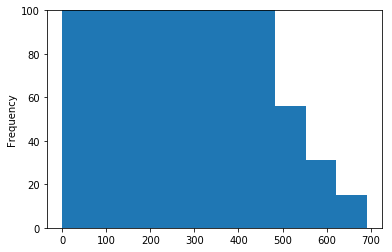

In [10]:
#look into the 'iws' column for outliers

pm_clean['iws'].plot(kind='hist',ylim=[0,100])
print(pm_clean['iws'].idxmax())
print(pm_clean.loc[55845:55850,'iws'])
#histogram and nearby entries reveal that the high values near row 55847 are not outliers, therefore no action is needed

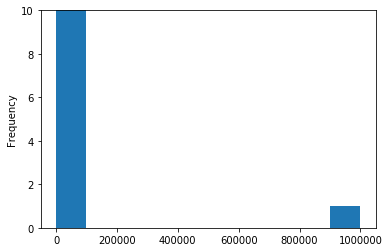

49612
49610         0.0
49611         0.0
49612    999990.0
49613         0.0
49614         0.0
49615         0.0
Name: precipitation, dtype: float64
count    172181.000000
mean          0.124579
std           1.177707
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          90.400002
Name: precipitation, dtype: float64


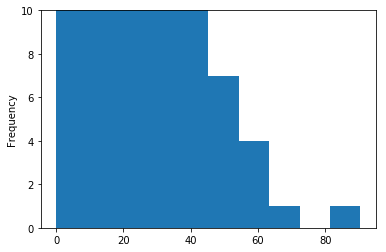

In [11]:
#look into the 'precipitation' column for outliers

pm_clean['precipitation'].plot(kind='hist',ylim=[0,10])
plt.show()
print(pm_clean['precipitation'].idxmax())
print(pm_clean.loc[49610:49615,'precipitation'])

#histogram reveals that the value at index 49612 is definely an outlier; replace its value with its previous entry 0.0
pm_clean.loc[49612,'precipitation']= 0.0

#check on the statistics and distribution after removing the outlier
print(pm_clean['precipitation'].describe())
pm_clean['precipitation'].plot(kind='hist',ylim=[0,10])
plt.show()

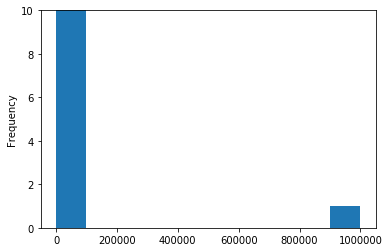

49612
49610         0.0
49611         0.0
49612    999990.0
49613         0.0
49614         0.0
49615         0.0
Name: iprec, dtype: float64
count    172181.000000
mean          0.652959
std           5.388967
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         226.400000
Name: iprec, dtype: float64


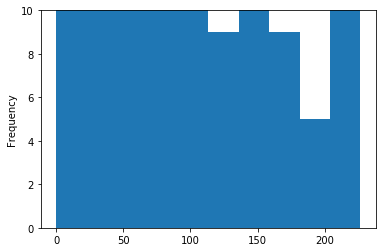

In [12]:
#look into the 'iprec' column for outliers

pm_clean['iprec'].plot(kind='hist',ylim=[0,10])
plt.show()
print(pm_clean['iprec'].idxmax())
print(pm_clean.loc[49610:49615,'iprec'])

#histogram reveals that the value at index 49612 is definely an outlier; replace its value with its previous entry 0.0
pm_clean.loc[49612,'iprec']= 0.0

#check on the statistics and distribution after removing the outlier
print(pm_clean['iprec'].describe())
pm_clean['iprec'].plot(kind='hist',ylim=[0,10])
plt.show()

174984
174982     967.333333
174983    1034.000000
174984    1134.666667
174985    1129.666667
174986    1053.000000
174987     992.000000
174988     955.000000
Name: pm_average, dtype: float64


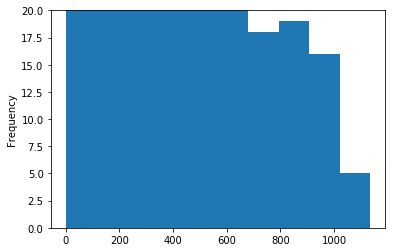

In [13]:
#look into the 'pm_average' column for outliers

pm_clean['pm_average'].plot(kind='hist',ylim=[0,20])
print(pm_clean['pm_average'].idxmax())
print(pm_clean.loc[174982:174988,'pm_average'])
#histogram and nearby entries reveal that the high values near row 174984 are not outliers, therefore no action is needed

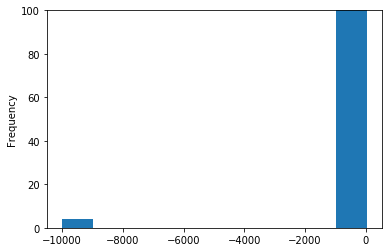

101487
101485      13.2
101486      13.0
101487   -9999.0
101488   -9999.0
101489   -9999.0
101490   -9999.0
101491      13.4
101492      11.4
101493      12.1
101494      12.6
101495      12.7
Name: dewp, dtype: float64
count    175801.000000
mean          8.591021
std          12.893325
min         -40.000000
25%           0.000000
50%          11.500000
75%          19.000000
max          28.000000
Name: dewp, dtype: float64


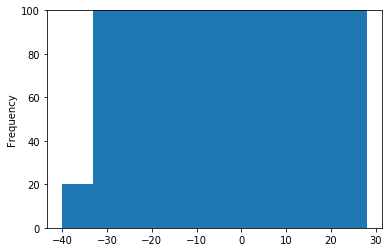

In [14]:
#look into the 'dewp' column for outliers

pm_clean['dewp'].plot(kind='hist',ylim=[0,100])
plt.show()
print(pm_clean['dewp'].idxmin())
print(pm_clean.loc[101485:101495,'dewp'])

#histogram reveals that the values at index 101487:101491 are definely outliers; replace their value with the average of their previous and later entries 13.2
pm_clean.loc[101487:101491,'dewp'] = 13.2

#check on the statistics and distribution after removing the outlier
print(pm_clean['dewp'].describe())
pm_clean['dewp'].plot(kind='hist',ylim=[0,100])
plt.show()

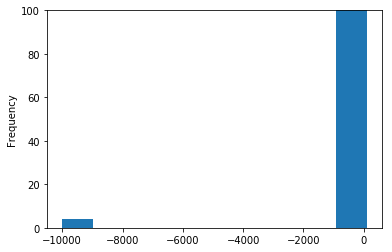

101487
101485     100.0
101486     100.0
101487   -9999.0
101488   -9999.0
101489   -9999.0
101490   -9999.0
101491     100.0
101492      89.0
101493      95.0
101494      96.0
101495      96.0
Name: humi, dtype: float64
count    175474.000000
mean         66.232095
std          22.850351
min           2.000000
25%          50.650000
50%          70.170000
75%          86.000000
max         100.000000
Name: humi, dtype: float64


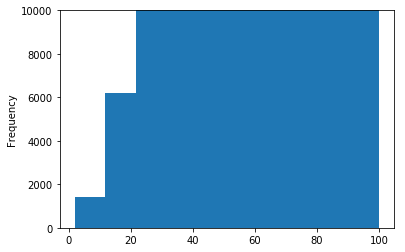

In [15]:
#look into the 'humi' column for outliers

pm_clean['humi'].plot(kind='hist',ylim=[0,100])
plt.show()
print(pm_clean['humi'].idxmin())
print(pm_clean.loc[101485:101495,'humi'])

#histogram reveals that the values at index 101487:101491 are definely outliers; replace their value with the average of their previous and later entries 100.0
pm_clean.loc[101487:101491,'humi'] = 100.0

#check on the statistics and distribution after removing the outlier
print(pm_clean['humi'].describe())
pm_clean['humi'].plot(kind='hist', ylim=[0,10000])
plt.show()

In [16]:
#look into the valid entries in the non-numerical column 'cbwd' (combined wind direction)

#explore the values in the column
print(pm_clean['cbwd'].value_counts())
#update all letters to uppercases for the valid entries in this column
pm_clean['cbwd']=pm_clean['cbwd'].str.upper()
#doublecheck the result
print(pm_clean['cbwd'].value_counts())

NW    44124
SE    41244
NE    38627
cv    29153
SW    22653
Name: cbwd, dtype: int64
NW    44124
SE    41244
NE    38627
CV    29153
SW    22653
Name: cbwd, dtype: int64


### Quick summary:
Now the main dataset pm_clean is cleaned up and ready for analysis. 
Doublecheck its content and save to file for further analysis.

In [17]:
#doublecheck
print(pm_clean.info())
print(pm_clean.head(3))
print(pm_clean.describe())

#save pm_clean to file
pm_clean.to_csv(path_or_buf='pm_clean.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176267 entries, 0 to 176266
Data columns (total 16 columns):
year             176267 non-null int64
month            176267 non-null int64
day              176267 non-null int64
hour             176267 non-null int64
season           176267 non-null int64
dewp             175801 non-null float64
humi             175474 non-null float64
pres             175460 non-null float64
temp             175801 non-null float64
cbwd             175801 non-null object
iws              175793 non-null float64
precipitation    172181 non-null float64
iprec            172181 non-null float64
city             176267 non-null object
pm_average       176267 non-null float64
date_time        176267 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(5), object(2)
memory usage: 21.5+ MB
None
   year  month  day  hour  season  dewp  humi    pres  temp cbwd   iws  \
0  2010      1    1    22       4 -17.0  38.0  1018.0  -5.0   NW  2.68   
1  

## 4. pm_stations

In [18]:
#copy relevant columns from pm_raw and store in a new dataframe named pm_stations

print(pm_raw.columns)
pm_stations = pm_raw[['year','month','day','hour','season','city','PM_US Post','PM_Dongsi','PM_Dongsihuan','PM_Nongzhanguan','PM_Jingan','PM_Xuhui','PM_City Station','PM_5th Middle School','PM_Caotangsi','PM_Shahepu','PM_Taiyuanjie','PM_Xiaoheyan']]

#overview of pm_stations
print(pm_stations.info())

Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi',
       'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec', 'city',
       'PM_Jingan', 'PM_Xuhui', 'PM_City Station', 'PM_5th Middle School',
       'PM_Caotangsi', 'PM_Shahepu', 'PM_Taiyuanjie', 'PM_Xiaoheyan', 'pm2.5',
       'Is', 'Ir'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306744 entries, 0 to 306743
Data columns (total 18 columns):
year                    306744 non-null int64
month                   306744 non-null int64
day                     306744 non-null int64
hour                    306744 non-null int64
season                  262919 non-null float64
city                    306744 non-null object
PM_US Post              167358 non-null float64
PM_Dongsi               25052 non-null float64
PM_Dongsihuan           20508 non-null float64
PM_Nongzhanguan         24931 non-null float64
PM_Jingan   

In [19]:
#drop irrelevant data in pm_stations

#drop all data from pm_stations where 'city' is 'beijing_2', these data is intended to be handled in a separate subset named pm_sr
pm_stations = pm_stations[pm_stations['city'] != 'beijing_2']
#update index
pm_stations.reset_index(drop=True,inplace=True)

#doublecheck rows for 'beijing_2' has been removed
print(pm_stations.info())
print(pm_stations['city'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262920 entries, 0 to 262919
Data columns (total 18 columns):
year                    262920 non-null int64
month                   262920 non-null int64
day                     262920 non-null int64
hour                    262920 non-null int64
season                  262919 non-null float64
city                    262920 non-null object
PM_US Post              167358 non-null float64
PM_Dongsi               25052 non-null float64
PM_Dongsihuan           20508 non-null float64
PM_Nongzhanguan         24931 non-null float64
PM_Jingan               24700 non-null float64
PM_Xuhui                25189 non-null float64
PM_City Station         32352 non-null float64
PM_5th Middle School    21095 non-null float64
PM_Caotangsi            24420 non-null float64
PM_Shahepu              24594 non-null float64
PM_Taiyuanjie           24388 non-null float64
PM_Xiaoheyan            24627 non-null float64
dtypes: float64(13), int64(4), object(1)
memo

In [20]:
#update all column names to be lowercase names

pm_stations.columns=pm_stations.columns.str.lower()
print(pm_stations.columns)

Index(['year', 'month', 'day', 'hour', 'season', 'city', 'pm_us post',
       'pm_dongsi', 'pm_dongsihuan', 'pm_nongzhanguan', 'pm_jingan',
       'pm_xuhui', 'pm_city station', 'pm_5th middle school', 'pm_caotangsi',
       'pm_shahepu', 'pm_taiyuanjie', 'pm_xiaoheyan'],
      dtype='object')


In [21]:
#deal with missing data: look into the one missing value in 'season' column

print(pm_stations[pm_stations['season'].isna()])
#look at its previous entry
print(pm_stations.loc[157750:157751,:])
#replace the missing value with the value (4.0) from its previous entry, because they are entries for the same day
pm_stations.loc[157751,'season'] = 4.0
assert pm_clean['season'].notnull().all()
#note that the'season' column has a data type of float64, whereas it only has four unique values of 1.0, 2.0, 3.0 and 4.0
print(pm_stations['season'].unique())
#convert the data type of 'season' column from float to int
pm_stations['season'] = pm_stations['season'].astype(int)
print(pm_stations.info())

        year  month  day  hour  season       city  pm_us post  pm_dongsi  \
157751  2015     12   31    23     NaN  guangzhou        63.0        NaN   

        pm_dongsihuan  pm_nongzhanguan  pm_jingan  pm_xuhui  pm_city station  \
157751            NaN              NaN        NaN       NaN             63.0   

        pm_5th middle school  pm_caotangsi  pm_shahepu  pm_taiyuanjie  \
157751                   NaN           NaN         NaN            NaN   

        pm_xiaoheyan  
157751           NaN  
        year  month  day  hour  season       city  pm_us post  pm_dongsi  \
157750  2015     12   31    22     4.0  guangzhou        60.0        NaN   
157751  2015     12   31    23     NaN  guangzhou        63.0        NaN   

        pm_dongsihuan  pm_nongzhanguan  pm_jingan  pm_xuhui  pm_city station  \
157750            NaN              NaN        NaN       NaN             60.0   
157751            NaN              NaN        NaN       NaN             63.0   

        pm_5th middle s

In [22]:
#deal with missing data: look into the missing values in columns with names featuring 'pm_'

#these columns store the pm2.5 data collected at individual stations. Each station is associated with a particular city
#for the cities the station doesn't belong to, their values will be labeled as NaN. 
#Therefore, it's expect to have many NaNs in these columns, since the rows are entries for five different cities

#drop rows where data of all the stations are missing (none of the stations have valid pm2.5 data)
stations=['pm_us post','pm_dongsi','pm_dongsihuan','pm_nongzhanguan','pm_jingan','pm_xuhui','pm_city station','pm_5th middle school','pm_caotangsi','pm_shahepu','pm_taiyuanjie','pm_xiaoheyan']
pm_stations.dropna(how='all',inplace=True, subset=stations)
pm_stations.reset_index(drop=True,inplace=True)
print(pm_stations.info())

#we will only compare the station data originated from the same city
#therefore it's ok to leave the rest of the missing values as they are

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175245 entries, 0 to 175244
Data columns (total 18 columns):
year                    175245 non-null int64
month                   175245 non-null int64
day                     175245 non-null int64
hour                    175245 non-null int64
season                  175245 non-null int64
city                    175245 non-null object
pm_us post              167358 non-null float64
pm_dongsi               25052 non-null float64
pm_dongsihuan           20508 non-null float64
pm_nongzhanguan         24931 non-null float64
pm_jingan               24700 non-null float64
pm_xuhui                25189 non-null float64
pm_city station         32352 non-null float64
pm_5th middle school    21095 non-null float64
pm_caotangsi            24420 non-null float64
pm_shahepu              24594 non-null float64
pm_taiyuanjie           24388 non-null float64
pm_xiaoheyan            24627 non-null float64
dtypes: float64(12), int64(5), object(1)
memory

In [23]:
#locate potential outliers

#look at the statistics for all numerical columns
print(pm_stations.describe())

#the min and max values in 'pm' columns are comparable (on the same scale) to each other, suggesting not obvious outliers

                year          month            day           hour  \
count  175245.000000  175245.000000  175245.000000  175245.000000   
mean     2013.350178       6.669982      15.783703      11.504237   
std         1.380209       3.445056       8.807852       6.924329   
min      2010.000000       1.000000       1.000000       0.000000   
25%      2012.000000       4.000000       8.000000       5.000000   
50%      2013.000000       7.000000      16.000000      12.000000   
75%      2014.000000      10.000000      23.000000      18.000000   
max      2015.000000      12.000000      31.000000      23.000000   

              season     pm_us post     pm_dongsi  pm_dongsihuan  \
count  175245.000000  167358.000000  25052.000000   20508.000000   
mean        2.503837      73.683929     89.154439      92.560806   
std         1.106118      68.540478     87.239267      88.027434   
min         1.000000       1.000000      3.000000       3.000000   
25%         2.000000      29.000000   

In [24]:
#create 'date_time' column from 'year','month','day','hour' and set as the DateTime Index

#note: previous investigation reveals the presence of some single digit data in certain columns ('month','day' and 'hour')
#these need to be converted to double digits for fitting to the time format string

#initialize an empty column named 'date_time'
pm_stations['date_time']=''
#iterate through 'year','month','day','hour' columns, convert int/float to string type, append to 'date_time' column
for idx, col in enumerate(pm_stations.columns[0:4]):
    #convert to string data type
    to_str = pm_stations[col].astype(str)
    #for 'month','day' and 'hour', update all string lengths to 2 by filling in 0 from the left  
    to_str = pd.Series([('0'+entry) if len(entry) < 2 else entry for entry in to_str])   
    #use string concatenation to append each time string to the 'date_time' column
    pm_stations['date_time'] += to_str
    
#doublecheck values in 'date_time' column before converting to DateTime format
print(pm_stations['date_time'].head())
#convert 'date_time' column from string object to DateTime object
pm_stations['date_time'] = pd.to_datetime(pm_stations['date_time'], format='%Y%m%d%H')
#doublecheck the values in 'date_time' column after converting
print(pm_stations['date_time'].head(25))

#set the 'date_time' column as the DateTime index for plotting the time series station data
pm_stations.set_index('date_time',inplace=True)
print(pm_stations.head(3))

0    2010010123
1    2010010200
2    2010010201
3    2010010202
4    2010010203
Name: date_time, dtype: object
0    2010-01-01 23:00:00
1    2010-01-02 00:00:00
2    2010-01-02 01:00:00
3    2010-01-02 02:00:00
4    2010-01-02 03:00:00
5    2010-01-02 04:00:00
6    2010-01-02 05:00:00
7    2010-01-02 06:00:00
8    2010-01-02 07:00:00
9    2010-01-02 08:00:00
10   2010-01-02 09:00:00
11   2010-01-02 10:00:00
12   2010-01-02 11:00:00
13   2010-01-02 12:00:00
14   2010-01-02 13:00:00
15   2010-01-02 14:00:00
16   2010-01-02 15:00:00
17   2010-01-02 16:00:00
18   2010-01-02 17:00:00
19   2010-01-02 18:00:00
20   2010-01-02 19:00:00
21   2010-01-02 20:00:00
22   2010-01-02 21:00:00
23   2010-01-02 22:00:00
24   2010-01-02 23:00:00
Name: date_time, dtype: datetime64[ns]
                     year  month  day  hour  season     city  pm_us post  \
date_time                                                                  
2010-01-01 23:00:00  2010      1    1    23       4  beijing       129.0 

### Quick summary:
Now the dataset pm_stations is cleaned up and ready for analysis. 
Doublecheck its content, then save to file for further analysis.

In [25]:
#doublecheck
print(pm_stations.info())
print(pm_stations.head(3))
print(pm_stations.describe())

#save pm_stations to file
pm_stations.to_csv(path_or_buf='pm_stations.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175245 entries, 2010-01-01 23:00:00 to 2015-12-31 23:00:00
Data columns (total 18 columns):
year                    175245 non-null int64
month                   175245 non-null int64
day                     175245 non-null int64
hour                    175245 non-null int64
season                  175245 non-null int64
city                    175245 non-null object
pm_us post              167358 non-null float64
pm_dongsi               25052 non-null float64
pm_dongsihuan           20508 non-null float64
pm_nongzhanguan         24931 non-null float64
pm_jingan               24700 non-null float64
pm_xuhui                25189 non-null float64
pm_city station         32352 non-null float64
pm_5th middle school    21095 non-null float64
pm_caotangsi            24420 non-null float64
pm_shahepu              24594 non-null float64
pm_taiyuanjie           24388 non-null float64
pm_xiaoheyan            24627 non-null float64
dtypes: float

## 5. pm_sr

In [26]:
#copy relevant columns from pm_raw and store in a new dataframe named pm_sr

print(pm_raw.columns)
pm_sr = pm_raw[['year','month','day','hour','city','DEWP','PRES','TEMP','cbwd','Iws','pm2.5','Is','Ir']]

#overview of pm_sr
print(pm_sr.info())

Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi',
       'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec', 'city',
       'PM_Jingan', 'PM_Xuhui', 'PM_City Station', 'PM_5th Middle School',
       'PM_Caotangsi', 'PM_Shahepu', 'PM_Taiyuanjie', 'PM_Xiaoheyan', 'pm2.5',
       'Is', 'Ir'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306744 entries, 0 to 306743
Data columns (total 13 columns):
year     306744 non-null int64
month    306744 non-null int64
day      306744 non-null int64
hour     306744 non-null int64
city     306744 non-null object
DEWP     305504 non-null float64
PRES     305163 non-null float64
TEMP     305506 non-null float64
cbwd     305513 non-null object
Iws      305501 non-null float64
pm2.5    41757 non-null float64
Is       43824 non-null float64
Ir       43824 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 30.4+ MB
N

In [27]:
#drop irrelevant data in pm_sr

#keep only rows from pm_sr where 'city' is 'beijing_2' and drop all other rows
#only these rows have measurement data in columns 'Ir' and 'Is' for cumulated hours of rain and cumulated hours of snow, respectively
pm_sr = pm_sr[pm_sr['city'] == 'beijing_2']
#update index
pm_sr.reset_index(drop=True,inplace=True)

#doublecheck rows for other than 'beijing_2' have been removed
print(pm_sr.info())
print(pm_sr['city'].value_counts())

#note: missing values are only present in column 'pm2.5'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
city     43824 non-null object
DEWP     43824 non-null float64
PRES     43824 non-null float64
TEMP     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
pm2.5    41757 non-null float64
Is       43824 non-null float64
Ir       43824 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 4.3+ MB
None
beijing_2    43824
Name: city, dtype: int64


In [28]:
##update all column names to be lowercase names

pm_sr.columns=pm_sr.columns.str.lower()
print(pm_sr.columns)

Index(['year', 'month', 'day', 'hour', 'city', 'dewp', 'pres', 'temp', 'cbwd',
       'iws', 'pm2.5', 'is', 'ir'],
      dtype='object')


In [29]:
#deal with missing data

print(pm_sr[pm_sr['pm2.5'].isna()].head())

#the main purpose of this subset pm_sr is to compare the impact of snow('Is') vs rain('Ir') on PM2.5 readings('pm2.5')
#therefore, drop rows with missing 'pm2.5' values as these rows are not useful
pm_sr.dropna(subset=['pm2.5'],inplace=True)
#reset index
pm_sr.reset_index(drop=True,inplace=True)

#check if all missing data has been taken care of
print(pm_sr.info())
assert pm_sr['pm2.5'].notnull().all()

   year  month  day  hour       city  dewp    pres  temp cbwd    iws  pm2.5  \
0  2010      1    1     0  beijing_2 -21.0  1021.0 -11.0   NW   1.79    NaN   
1  2010      1    1     1  beijing_2 -21.0  1020.0 -12.0   NW   4.92    NaN   
2  2010      1    1     2  beijing_2 -21.0  1019.0 -11.0   NW   6.71    NaN   
3  2010      1    1     3  beijing_2 -21.0  1019.0 -14.0   NW   9.84    NaN   
4  2010      1    1     4  beijing_2 -20.0  1018.0 -12.0   NW  12.97    NaN   

    is   ir  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 13 columns):
year     41757 non-null int64
month    41757 non-null int64
day      41757 non-null int64
hour     41757 non-null int64
city     41757 non-null object
dewp     41757 non-null float64
pres     41757 non-null float64
temp     41757 non-null float64
cbwd     41757 non-null object
iws      41757 non-null float64
pm2.5    41757 non-nul

               year         month           day          hour          dewp  \
count  41757.000000  41757.000000  41757.000000  41757.000000  41757.000000   
mean    2012.042771      6.513758     15.685514     11.502311      1.750174   
std        1.415311      3.454199      8.785539      6.924848     14.433658   
min     2010.000000      1.000000      1.000000      0.000000    -40.000000   
25%     2011.000000      4.000000      8.000000      5.000000    -10.000000   
50%     2012.000000      7.000000     16.000000     12.000000      2.000000   
75%     2013.000000     10.000000     23.000000     18.000000     15.000000   
max     2014.000000     12.000000     31.000000     23.000000     28.000000   

               pres          temp           iws         pm2.5            is  \
count  41757.000000  41757.000000  41757.000000  41757.000000  41757.000000   
mean    1016.442896     12.401561     23.866747     98.613215      0.055344   
std       10.300733     12.175215     49.617495    

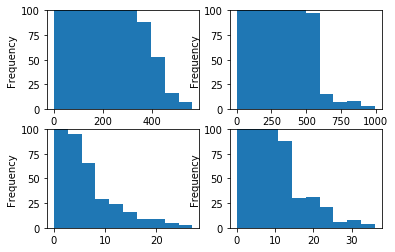

In [30]:
#locate potential outliers

#look at the statistics for all numerical columns
print(pm_sr.describe())

#check on the max values in columns 'Iws','pm2.5','Is' and 'Ir'
plt.subplot(2,2,1)
pm_sr['iws'].plot(kind='hist',ylim=[0,100])
plt.subplot(2,2,2)
pm_sr['pm2.5'].plot(kind='hist',ylim=[0,100])
plt.subplot(2,2,3)
pm_sr['is'].plot(kind='hist',ylim=[0,100])
plt.subplot(2,2,4)
pm_sr['ir'].plot(kind='hist',ylim=[0,100])

#these histograms reveal that none of the max values in these columns are obvious outliers, therefore no action is needed

In [31]:
#check on non-numerical column 'cbwd'
print(pm_sr['cbwd'].value_counts())

#update all values in this column to uppercases
pm_sr['cbwd']=pm_sr['cbwd'].str.upper()

#doublecheck
print(pm_sr['cbwd'].value_counts())

SE    14573
NW    13484
cv     8944
NE     4756
Name: cbwd, dtype: int64
SE    14573
NW    13484
CV     8944
NE     4756
Name: cbwd, dtype: int64


In [32]:
#create a new column named 'date_time' storing the DateTime format data from time-related columns:'year','month','day','hour'

#initialize an empty column named 'date_time'
pm_sr['date_time']=''
#iterate through 'year','month','day','hour' columns, convert int/float to string type, append to 'date_time' column
for idx, col in enumerate(pm_sr.columns[0:4]):
    #convert to string data type
    to_str = pm_sr[col].astype(str)
    #for 'month','day' and 'hour', update all string lengths to 2 by filling in 0 from the left  
    to_str = pd.Series([('0'+entry) if len(entry) < 2 else entry for entry in to_str])   
    #use string concatenation to append each time string to the 'date_time' column
    pm_sr['date_time'] += to_str
    
#convert 'date_time' column from string object to DateTime object
pm_sr['date_time'] = pd.to_datetime(pm_sr['date_time'], format='%Y%m%d%H')
#doublecheck the values in 'date_time' column after converting
print(pm_sr['date_time'].head(25))

0    2010-01-02 00:00:00
1    2010-01-02 01:00:00
2    2010-01-02 02:00:00
3    2010-01-02 03:00:00
4    2010-01-02 04:00:00
5    2010-01-02 05:00:00
6    2010-01-02 06:00:00
7    2010-01-02 07:00:00
8    2010-01-02 08:00:00
9    2010-01-02 09:00:00
10   2010-01-02 10:00:00
11   2010-01-02 11:00:00
12   2010-01-02 12:00:00
13   2010-01-02 13:00:00
14   2010-01-02 14:00:00
15   2010-01-02 15:00:00
16   2010-01-02 16:00:00
17   2010-01-02 17:00:00
18   2010-01-02 18:00:00
19   2010-01-02 19:00:00
20   2010-01-02 20:00:00
21   2010-01-02 21:00:00
22   2010-01-02 22:00:00
23   2010-01-02 23:00:00
24   2010-01-03 00:00:00
Name: date_time, dtype: datetime64[ns]


### Quick summary:
Now the dataset pm_sr is cleaned up and ready for analysis. 
Doublecheck its content, then save to file for further analysis.

In [33]:
#doublecheck
print(pm_sr.info())
print(pm_sr.head(3))
print(pm_sr.describe())

#save pm_sr to file
pm_sr.to_csv(path_or_buf='pm_sr.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 14 columns):
year         41757 non-null int64
month        41757 non-null int64
day          41757 non-null int64
hour         41757 non-null int64
city         41757 non-null object
dewp         41757 non-null float64
pres         41757 non-null float64
temp         41757 non-null float64
cbwd         41757 non-null object
iws          41757 non-null float64
pm2.5        41757 non-null float64
is           41757 non-null float64
ir           41757 non-null float64
date_time    41757 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(4), object(2)
memory usage: 4.5+ MB
None
   year  month  day  hour       city  dewp    pres  temp cbwd   iws  pm2.5  \
0  2010      1    2     0  beijing_2 -16.0  1020.0  -4.0   SE  1.79  129.0   
1  2010      1    2     1  beijing_2 -15.0  1020.0  -4.0   SE  2.68  148.0   
2  2010      1    2     2  beijing_2 -11.0  1021.0  -5.0   SE  3.57  1